# Main Script Bank Telemarketing Dataset

First required packages and the data is loaded. Note that both the training- and validation dataset as well as the test dataset are taken from the bank-full.csv dataset. A random sampel of 6'000 nodes is taken for both subsets. 

If the dataset would be considered for the results chapter, the dataset would have first been randomly split into two datasets and then subsampled separately. The results do however not differ in any significant way. When sampling from the same dataset, technically identical observations could be present in both training and test dataset. Given the large size of the original datset with over 45'000 observations, this is unlikely to cause a problem or significantly bias the results.

In [67]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
import networkx as nx

df = pd.read_csv('bank-full.csv',sep=';')
df_train_valid = df.sample(n=6000,replace=False)
df_feature_train = df_train_valid.copy(deep=True)
# df_train_valid = pd.read_csv('bank.csv',sep=';')
df_train_valid.reset_index(inplace=True,drop=True)
df_test = df.sample(n=6000,replace=False)
df_test.reset_index(inplace=True,drop=True)

Below the unbalanced label distribution for both datasets is shown

In [68]:
df_train_valid.y.value_counts(normalize=True)

no     0.882167
yes    0.117833
Name: y, dtype: float64

In [69]:
df_test.y.value_counts(normalize=True)

no     0.883167
yes    0.116833
Name: y, dtype: float64

In [70]:
df_train_valid

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,management,single,tertiary,no,149,yes,no,unknown,3,jun,220,2,-1,0,unknown,no
1,35,technician,single,tertiary,no,1529,no,no,unknown,23,may,95,4,-1,0,unknown,no
2,35,services,divorced,secondary,no,78,yes,no,telephone,13,may,630,3,371,3,failure,no
3,32,blue-collar,divorced,secondary,no,0,no,no,telephone,9,jul,49,1,-1,0,unknown,no
4,30,management,single,tertiary,no,147,no,no,cellular,9,sep,234,1,100,1,failure,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,28,admin.,single,secondary,no,177,yes,yes,cellular,6,may,150,1,-1,0,unknown,no
5996,27,blue-collar,married,secondary,no,1600,yes,no,unknown,21,may,135,1,-1,0,unknown,no
5997,46,admin.,married,unknown,no,1106,no,no,telephone,9,feb,14,13,-1,0,unknown,no
5998,40,technician,single,secondary,no,57,no,yes,cellular,6,aug,102,4,-1,0,unknown,no


## The variables are recoded into a useful format

In [71]:
df_train_valid.age = df_train_valid.age.apply(lambda x: 0 if x < 25 else(1 if x < 35 else(2 if x < 50 else(3 if x < 65 else 4))))

#df.job = df.job.apply(lambda x: 0 if x == 'unemployed' else(1 if x == 'services' \
#                            else(2 if x == 'management' else(3 if x == 'blue-collar' \
#                                else(4 if x == 'self-employed' else(5 if x == 'technician' \
#                                    else(6 if x == 'entrepreneur' else(7 if x == 'admin.' \
#                        else(8 if x =='student' else(9 if x == 'housemaid' \
#                            else(10 if x == 'retired' else 11)))))))))))

#df.job = df.job.apply(lambda x: 0 if x == 'unemployed' or 'unknown' else(1 if x == 'services' \
#                        or x == 'management' or x == 'admin.' else(2 if x == 'blue-collar' or x == 'technician' \
#                                    or x == 'housemaid' else(3 if x == 'self-employed' or x == 'entrepreneur' \
#                                        else(4 if x == 'student' else 5)))))

df_train_valid.job = df_train_valid.job.apply(lambda x: 0 if x == 'student' else(2 if x == 'retired' else(3 if x == 'unemployed' or x == 'unknown' else 1)))


df_train_valid.marital = df_train_valid.marital.apply(lambda x: 0 if x == 'single' else(1 if x == 'married' else 2))

df_train_valid.education = df_train_valid.education.apply(lambda x: 0 if x == 'primary' else(1 if x == 'secondary' else(2 if x == 'tertiary' else 3)))

df_train_valid.default = df_train_valid.default.apply(lambda x: 0 if x == 'no' else 1)

df_train_valid.balance = df_train_valid.balance.apply(lambda x: 0 if x < 0 else(1 if x < 69. else(2 if x < 444. else(3 if x < 1480 else 4))))

df_train_valid.housing = df_train_valid.housing.apply(lambda x: 0 if x == 'no' else 1)

df_train_valid.loan = df_train_valid.loan.apply(lambda x: 0 if x == 'no' else 1)

df_train_valid.contact = df_train_valid.contact.apply(lambda x: 0 if x == 'telephone' else(1 if x == 'cellular' else 2))

#df_train_valid.duration = df_train_valid.duration.apply(lambda x: 0 if x < 104. else(1 if x < 185 else(2 if x < 329 else 3)))

df_train_valid.pdays = df_train_valid.pdays.apply(lambda x: 1 if x > 150 or x == -1 else 0)

df_train_valid.poutcome = df_train_valid.poutcome.apply(lambda x: 0 if x == 'failure' else(1 if x == 'success' else 2))

df_train_valid.y = df_train_valid.y.apply(lambda x: 0 if x == 'no' else 1)

df_train_valid.drop(columns = ['day','month'],inplace=True)


In [72]:
df_train_valid

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y
0,1,1,0,2,0,2,1,0,2,220,2,1,0,2,0
1,2,1,0,2,0,4,0,0,2,95,4,1,0,2,0
2,2,1,2,1,0,2,1,0,0,630,3,1,3,0,0
3,1,1,2,1,0,1,0,0,0,49,1,1,0,2,0
4,1,1,0,2,0,2,0,0,1,234,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,1,1,0,1,0,2,1,1,1,150,1,1,0,2,0
5996,1,1,1,1,0,4,1,0,2,135,1,1,0,2,0
5997,2,1,1,3,0,3,0,0,0,14,13,1,0,2,0
5998,2,1,0,1,0,1,0,1,1,102,4,1,0,2,0


## The Correlation Matrix of the Dataset

In [73]:
corr = df_train_valid.corr()
corr

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y
age,1.000000,0.274320,0.399614,-0.096809,-0.028773,0.098931,-0.142981,-0.016090,-0.052196,0.003453,-0.004871,-0.021839,0.025998,-0.011383,0.016849
job,0.274320,1.000000,0.117212,-0.059357,0.006922,0.034112,-0.078665,-0.020840,-0.010238,0.020014,-0.021916,-0.022149,-0.006763,-0.001747,0.014351
marital,0.399614,0.117212,1.000000,-0.117485,-0.014417,-0.016166,-0.007557,0.043703,0.009663,-0.009274,0.001964,0.043839,-0.036105,0.036344,-0.037679
education,-0.096809,-0.059357,-0.117485,1.000000,-0.022586,0.084611,-0.085415,-0.054700,-0.078784,-0.007498,0.018152,-0.073583,0.029981,-0.034904,0.072417
default,-0.028773,0.006922,-0.014417,-0.022586,1.000000,-0.185624,0.010664,0.051677,0.027122,0.004231,0.036835,0.031449,-0.033316,0.044562,-0.020213
balance,0.098931,0.034112,-0.016166,0.084611,-0.185624,1.000000,-0.084302,-0.130020,-0.075008,0.040768,-0.034759,-0.096150,0.067154,-0.064301,0.117830
housing,-0.142981,-0.078665,-0.007557,-0.085415,0.010664,-0.084302,1.000000,0.028926,0.206300,-0.002854,-0.009776,0.094873,0.027739,-0.068045,-0.142651
loan,-0.016090,-0.020840,0.043703,-0.054700,0.051677,-0.130020,0.028926,1.000000,-0.009170,-0.001713,-0.005546,0.043461,-0.005752,0.019180,-0.060877
contact,-0.052196,-0.010238,0.009663,-0.078784,0.027122,-0.075008,0.206300,-0.009170,1.000000,0.011466,0.003577,0.127932,-0.157515,0.200889,-0.123880
duration,0.003453,0.020014,-0.009274,-0.007498,0.004231,0.040768,-0.002854,-0.001713,0.011466,1.000000,-0.092672,-0.001832,0.001889,0.023283,0.404558


## Duration Attribute

It is investigated, whether the attribute duration should be added as an attribute. This variable has the largest correlation with the label, which why it is considered as a partial substitute for the label. Using duration as an additional attribute unfortunately did not show to improve the classification accuracy. For that reason, the graph shown in the master's thesis including the results correspond to the graph which does not make use of the attribute duration. For simulation purposes, the duration attribute can easily be adding its link-affinity matrix to the link-affinity dictionary used in the MAG model.

In [74]:
df_train_valid.duration.describe()

count    6000.000000
mean      256.852000
std       256.950951
min         1.000000
25%       103.000000
50%       178.000000
75%       316.000000
max      3422.000000
Name: duration, dtype: float64

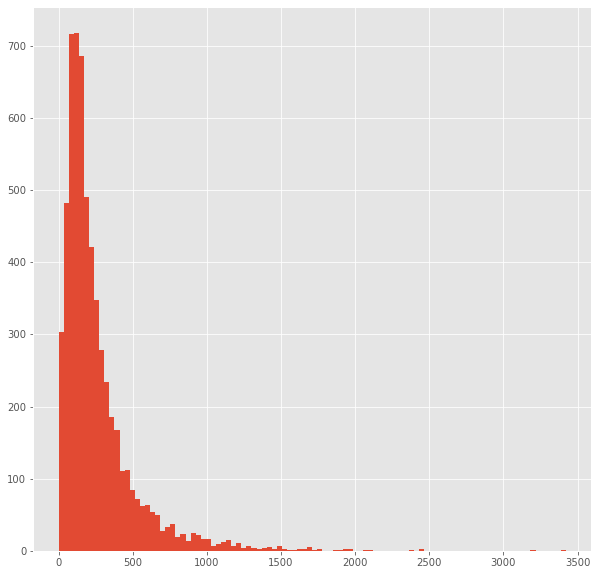

In [75]:
plt.figure(figsize=(10,10))
plt.hist(df_train_valid.duration,bins=100)
#plt.hist(df_train_valid.y,bins=100)
plt.show()

In [76]:
value_comparison = (df_train_valid.duration > 400)

In [77]:
value_comparison

0       False
1       False
2        True
3       False
4       False
        ...  
5995    False
5996    False
5997    False
5998    False
5999    False
Name: duration, Length: 6000, dtype: bool

In [78]:
df_train_valid.y[value_comparison].sum()

366

(array([652.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 366.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

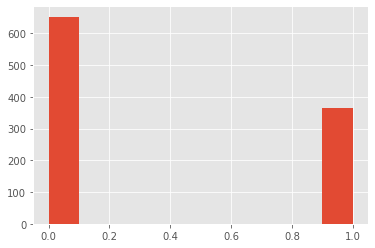

In [79]:
plt.hist(df_train_valid.y[value_comparison==True])

## Attribute Selection

In [80]:
#genvars = df_train_valid.drop(columns=['pdays','campaign','poutcome','previous','contact','loan','default','y'])
genvars = df_train_valid[['age','job','marital','education','balance','housing']]
#genvars = df_train_valid[['age','job','marital','education','balance','housing','duration']]
genvars.describe()

,age,job,marital,education,balance,housing
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,1.902000,1.093000,0.842167,1.230000,2.417500,0.554667
std,0.806539,0.441267,0.609358,0.759515,1.262851,0.497044
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000
50%,2.000000,1.000000,1.000000,1.000000,3.000000,1.000000
75%,2.000000,1.000000,1.000000,2.000000,4.000000,1.000000
max,4.000000,3.000000,2.000000,3.000000,4.000000,1.000000


## Link-affinity matrices

To create the biased graph, add the link-affinity matrix of the label to the affinity matrix dictionary. Further, the label must be added to the matrix containing the attributes

In [34]:
# age
age_alpha0 = 0.90
age_beta1 = 0.80
age_beta2 = 0.60
age_beta3 = 0.40
age_beta4 = 0.20

aff_age = np.array([[age_alpha0,age_beta1,age_beta2,age_beta3,age_beta4],
                    [age_beta1,age_alpha0,age_beta1,age_beta2,age_beta3],
                    [age_beta2,age_beta1,age_alpha0,age_beta1,age_beta2],
                    [age_beta3,age_beta2,age_beta1,age_alpha0,age_beta1],
                    [age_beta4,age_beta3,age_beta2,age_beta1,age_alpha0]])


# job

job_alpha0 = 0.90 # self
job_beta_wf = 0.60 # workforce
job_beta_nwf = 0.60 # not worforce

#aff_job = np.array([[job_alpha0, job_beta_wf , job_beta_wf , job_beta_wf , job_beta_nwf, job_beta_nwf],
#                    [job_beta_nwf, job_alpha0, job_beta_wf, job_beta_wf, job_beta_nwf, job_beta_nwf],
#                    [job_beta_nwf, job_beta_wf, job_alpha0, job_beta_wf, job_beta_nwf, job_beta_nwf],
#                    [job_beta_nwf, job_beta_wf, job_beta_wf, job_alpha0, job_beta_nwf, job_beta_nwf],
#                    [job_beta_nwf, job_beta_wf, job_beta_wf, job_beta_wf, job_alpha0, job_beta_nwf],
#                    [job_beta_nwf, job_beta_wf, job_beta_wf, job_beta_wf, job_beta_nwf, job_alpha0]])

# employment
emp_alpha0 = 0.90 # self
emp_beta_wf = 0.75 # beta workforce / employed / unemployed vs student
emp_beta_ret = 0.70 # beta retired vs workforce
emp_beta_sr = 0.20 # gen gap student / retired

aff_job = np.array([[emp_alpha0,emp_beta_wf,emp_beta_sr,emp_beta_wf],
                    [emp_beta_wf,emp_alpha0,emp_beta_ret,emp_beta_wf],
                    [emp_beta_sr,emp_beta_ret,emp_alpha0,emp_beta_ret],
                    [emp_beta_wf,emp_beta_wf,emp_beta_ret,emp_alpha0]])


# marital

mar_alpha0 = 0.85
mar_beta1 = 0.65

aff_mar = np.array([[mar_alpha0, mar_beta1, mar_beta1],
                    [mar_beta1, mar_alpha0, mar_beta1],
                    [mar_beta1, mar_beta1, mar_alpha0]])

# education
edu_alpha0 = 0.85
edu_beta1 = 0.70
edu_beta2 = 0.55
edu_beta3 = 0.40

aff_edu = np.array([[edu_alpha0,edu_beta1,edu_beta2,edu_beta3],
                    [edu_beta1,edu_alpha0,edu_beta1,edu_beta2],
                    [edu_beta2,edu_beta1,edu_alpha0,edu_beta1],
                    [edu_beta3,edu_beta2,edu_beta1,edu_alpha0]])


# balance
inc_alpha0 = 0.85
inc_beta1 = 0.70
inc_beta2 = 0.60
inc_beta3 = 0.50
inc_beta4 = 0.40
inc_beta5 = 0.25

aff_bal = np.array([[inc_alpha0,inc_beta1,inc_beta2,inc_beta3,inc_beta4],
                    [inc_beta1,inc_alpha0,inc_beta1,inc_beta2,inc_beta3],
                    [inc_beta2,inc_beta1,inc_alpha0,inc_beta1,inc_beta2],
                    [inc_beta3,inc_beta2,inc_beta1,inc_alpha0,inc_beta1],
                    [inc_beta4,inc_beta3,inc_beta2,inc_beta2,inc_alpha0]])

# housing
hous_alpha0 = 0.60
hous_beta1 = 0.40

aff_hous = np.array([[hous_alpha0,hous_beta1],
                     [hous_beta1,hous_alpha0]])


# duration
dur_alpha0 = 0.70
dur_alpha1 = 0.95
dur_beta1 = 0.25

aff_dur = np.array([[dur_alpha0,dur_beta1],
                  [dur_beta1,dur_alpha1]])

# outcome

y_alpha1 = 0.95
y_beta1 = 0.25

aff_y = np.array([[y_alpha1,y_beta1],
                  [y_beta1,y_alpha1]])

aff = {}
aff = {0:aff_age, 1:aff_job ,2:aff_mar ,3:aff_edu ,4:aff_bal ,5:aff_hous}

## MAG Model

In [35]:
x = genvars.to_numpy()
x = x.astype(int)
x = x.T

P_u_v = np.empty((len(x.T),len(x.T)))
prob_u_v = np.empty((len(x),1))
u = np.empty((len(x),1))
v = np.empty((len(x),1))

# create probability for connection between u and v
for i in range(len(x.T)):
    u = x[:,i]

    for k in range(len(x.T)):
        v = x[:,k]

        for j in range(len(x)):
            aff_current = aff[j]
            prob_u_v[j] = aff_current[u[j],v[j]]

        P_u_v[i,k] = np.prod(prob_u_v) 

In [36]:
A = np.triu(P_u_v,1)

for i in range(len(P_u_v)):
    for j in range(len(P_u_v)):
        if A[i,j] > np.random.rand():
            A[i,j] = 1
        else:
            A[i,j] = 0


In [37]:
A = A + A.T
np.sum(A) / 2

2260306.0

## Create and Plot the Graph

In [38]:
G = nx.from_numpy_matrix(A)

In [39]:
nx.is_connected(G)

True

In [40]:
# nx.draw(G,node_size=20)

In [41]:
features = pd.Series(df_train_valid.y)

In [42]:
df_train_valid.drop(columns=['y'],inplace=True)

In [43]:
not_invest = features.index[features == 0].tolist()
invest = features.index[features == 1].tolist()

In [44]:
pos = nx.spring_layout(G)

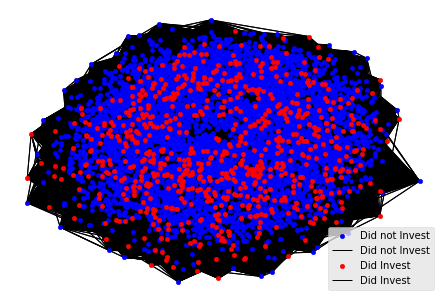

In [45]:
nx.draw(G,pos,nodelist=not_invest,node_size=20,node_color='b',label='Did not Invest')
nx.draw(G,pos,nodelist=invest,node_size=20,node_color='r',label='Did Invest')
plt.legend()
plt.show()

## Prepare the Data for GNNs

In [46]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [47]:
df_train_valid

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome
0,2,1,0,2,0,3,1,0,1,313,1,0,2,1
1,2,1,1,1,0,4,0,0,1,156,1,0,0,2
2,2,1,1,2,0,2,0,0,1,163,4,0,0,2
3,2,0,1,3,0,1,0,0,2,115,1,0,0,2
4,1,1,1,0,0,3,1,0,2,244,2,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,1,1,1,0,0,2,1,0,1,149,2,0,0,2
5996,1,1,0,1,0,3,0,0,1,100,1,0,0,2
5997,2,1,2,1,0,0,1,1,1,469,1,0,1,0
5998,2,1,1,2,0,4,0,0,0,127,4,0,0,2


In [81]:
df_feature_train.reset_index(inplace=True,drop=True)
df_train_valid.age = df_feature_train.age
df_train_valid.balance = df_feature_train.balance
#df_train_valid.drop(columns = ['day','month'],inplace=True)
df_train_valid.duration = df_feature_train.duration


In [82]:
#df_train_valid.drop(columns = ['pdays'],inplace=True)
#df_train_valid.previous = df_feature_train.previous
df_train_valid.describe()

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,41.123667,1.093000,0.842167,1.230000,0.018833,1374.615333,0.554667,0.150000,1.227667,256.852000,2.784167,0.951000,0.548833,1.765000,0.117833
std,10.632257,0.441267,0.609358,0.759515,0.135947,2713.019230,0.497044,0.357101,0.554875,256.950951,3.008891,0.215886,2.024919,0.620623,0.322438
min,19.000000,0.000000,0.000000,0.000000,0.000000,-1884.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,33.000000,1.000000,0.000000,1.000000,0.000000,67.000000,0.000000,0.000000,1.000000,103.000000,1.000000,1.000000,0.000000,2.000000,0.000000
50%,39.000000,1.000000,1.000000,1.000000,0.000000,453.000000,1.000000,0.000000,1.000000,178.000000,2.000000,1.000000,0.000000,2.000000,0.000000
75%,49.000000,1.000000,1.000000,2.000000,0.000000,1487.500000,1.000000,0.000000,2.000000,316.000000,3.000000,1.000000,0.000000,2.000000,0.000000
max,89.000000,3.000000,2.000000,3.000000,1.000000,34230.000000,1.000000,1.000000,2.000000,3422.000000,46.000000,1.000000,58.000000,2.000000,1.000000


In [50]:
# import all required packages
import time
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

import networkx as nx
import seaborn as sns
import statsmodels.api as sm

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

import dgl
import dgl.nn as dglnn

import torch
import torch.nn as nn
import torch.nn.functional as F
#from sage import SAGEConv

import tqdm

import sklearn.metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

Using backend: pytorch


In [51]:
def norm(x):
    return F.normalize(x, p=2, dim=-1)

Norm = norm

## Prepare the dgl data and assign features and label

In [52]:
import dgl
import dgl.nn as dglnn
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler

G_dgl = dgl.from_networkx(G)
feat = df_train_valid.copy(deep=True)
#feat = pd.get_dummies(feat[['job','marital']])
scale = StandardScaler()
feat = pd.DataFrame(scale.fit_transform(feat))

embedding = torch.tensor(feat.values,dtype=torch.float)

G_dgl.ndata['feat'] =  embedding
G_dgl.ndata['train_mask'] = torch.zeros(len(G_dgl.nodes()), dtype=torch.bool).bernoulli(0.8)
G_dgl.ndata['label'] = torch.tensor(features)

In [53]:
feat

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-0.364603,-0.221136,-1.387675,1.032529,-0.139169,-0.111481,0.880723,-0.449091,-0.411405,0.191501,-0.572084,0.327688,-1.206530
1,-0.364603,-0.221136,0.268591,-0.301775,-0.139169,0.397069,-1.135431,-0.449091,-0.411405,-0.405015,-0.572084,-0.150980,0.385548
2,-0.553288,-0.221136,0.268591,1.032529,-0.139169,-0.299685,-1.135431,-0.449091,-0.411405,-0.378419,0.397458,-0.150980,0.385548
3,-0.364603,-2.477628,0.268591,2.366833,-0.139169,-0.427824,-1.135431,-0.449091,1.399621,-0.560793,-0.572084,-0.150980,0.385548
4,-0.741974,-0.221136,0.268591,-1.636079,-0.139169,-0.140128,0.880723,-0.449091,1.399621,-0.070662,-0.248903,-0.150980,0.385548
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,-1.213687,-0.221136,0.268591,-1.636079,-0.139169,-0.349585,0.880723,-0.449091,-0.411405,-0.431611,-0.248903,-0.150980,0.385548
5996,-0.930659,-0.221136,-1.387675,-0.301775,-0.139169,-0.115178,-1.135431,-0.449091,-0.411405,-0.617785,-0.572084,-0.150980,0.385548
5997,0.767509,-0.221136,1.924858,-0.301775,-0.139169,-0.493125,0.880723,2.226722,-0.411405,0.784219,-0.572084,0.088354,-2.798608
5998,-0.175918,-0.221136,0.268591,1.032529,-0.139169,0.493173,-1.135431,-0.449091,-2.222430,-0.515200,0.397458,-0.150980,0.385548


In [54]:
G_dgl.ndata['val_mask'] = torch.empty(len(G_dgl.nodes()))
for i in range(len(G_dgl.ndata['train_mask'])):
    if G_dgl.ndata['train_mask'][i] == True:
        G_dgl.ndata['val_mask'][i] = False
    else:
        G_dgl.ndata['val_mask'][i] = True

G_dgl.ndata['val_mask'] = G_dgl.ndata['val_mask'].type(torch.bool)

In [55]:
node_features = G_dgl.ndata['feat']
node_labels = G_dgl.ndata['label']
train_mask = G_dgl.ndata['train_mask']
valid_mask = G_dgl.ndata['val_mask']
n_features = node_features.shape[1]
n_labels = int(node_labels.max().item() + 1)

In [56]:
train_nodes = (train_mask == True).nonzero(as_tuple=False)
train_nids = torch.reshape(train_nodes,(-1,))
valid_nodes = (valid_mask == True).nonzero(as_tuple=False)
valid_nids = torch.reshape(valid_nodes,(-1,))

## Define Dataloaders for minibatch training

In [57]:
batch_size = 50
#sampler = dgl.dataloading.MultiLayerNeighborSampler([4, 4, 4])
sampler = dgl.dataloading.MultiLayerNeighborSampler([5, 10])
#sampler = dgl.dataloading.MultiLayerNeighborSampler([None])
train_dataloader = dgl.dataloading.NodeDataLoader(
    G_dgl, train_nids, sampler,
    batch_size=batch_size,
    shuffle=True,
    drop_last=False,
    num_workers=0
)

In [58]:
batch_size = len(valid_nids)
valid_dataloader = dgl.dataloading.NodeDataLoader(
    G_dgl, valid_nids, sampler,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=0
)

In [59]:
print(len(train_nids))
print(len(valid_nids))
print(len(G.nodes()))

4759
1241
6000


## Define GraphSage Model

In [60]:
import tqdm
import sklearn.metrics

class SAGE(nn.Module):
    def __init__(self, in_feats, n_hidden, n_classes, n_layers,agg_type='pool'):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.layers = nn.ModuleList()
        self.layers.append(dglnn.SAGEConv(in_feats, n_hidden, aggregator_type=agg_type, bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        for i in range(1, n_layers - 1):
            self.layers.append(dglnn.SAGEConv(n_hidden, n_hidden, aggregator_type=agg_type, bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        self.layers.append(dglnn.SAGEConv(n_hidden, n_classes, aggregator_type=agg_type, bias=True, feat_drop=0.02,norm=Norm,activation=None))
        
    def forward(self, bipartites, x):
        for l, (layer, bipartite) in enumerate(zip(self.layers, bipartites)):
            x = layer(bipartite, x)
        return x

## Train GraphSage and get Results

In [61]:
model = SAGE(n_features, len(feat), n_labels, 2) #n_layers
opt = torch.optim.Adam(model.parameters(),lr=0.002)

In [62]:
import time

# GraphSage
best_accuracy = 0
best_model_path = 'model.pt'
epoch_losses_train = []
plot_loss_valid = []
train_acc = []
valid_acc = []
dur = []

for epoch in range(200):
    t0 = time.time()
    model.train()
    loss_epoch = 0
    accuracy_epoch = 0
    for step, (input_nodes, output_nodes, bipartites) in enumerate(train_dataloader):
        inputs = node_features[input_nodes]
        labels = node_labels[output_nodes]
        logits = model(bipartites, inputs)
        predictions = F.log_softmax(logits,dim=1)

        loss = F.cross_entropy(logits, labels)
        loss_epoch += loss.detach().item()
        opt.zero_grad()
        loss.backward()
        opt.step()

        accuracy = accuracy_score(labels.numpy(), predictions.argmax(1).detach().numpy())
        accuracy_epoch += accuracy
    accuracy_epoch /= (step + 1)
    loss_epoch /= (step + 1)
    epoch_losses_train.append(loss_epoch)
    train_acc.append(accuracy_epoch)
    print('Epoch: {}, Training Accuracy: {:.3f}, Training Loss: {:.3f}'.format(epoch, accuracy_epoch, loss_epoch))
        
    model.eval()
    
    predictions = []
    labels = []
    with torch.no_grad():
        for input_nodes, output_nodes, bipartites in valid_dataloader:
            inputs = node_features[input_nodes]
            labels.append(node_labels[output_nodes].numpy())
            predictions.append(F.log_softmax(model(bipartites, inputs),dim=1).argmax(1).numpy())
            valid_logits = model(bipartites, inputs)
            valid_labels = node_labels[output_nodes]
            valid_loss = F.cross_entropy(valid_logits, valid_labels)

        predictions = np.concatenate(predictions)
        labels = np.concatenate(labels)
        
        accuracy = accuracy_score(labels, predictions)
        dur.append(time.time() - t0)
        print('Epoch: {}, Validation Accuracy: {:.3f}, Validation Loss: {:.3f}, Time: {:.4f}'.format(epoch, accuracy, valid_loss.item(), np.mean(dur)))
        valid_acc.append(accuracy.item())
        plot_loss_valid.append(valid_loss.item())
    
torch.save(model.state_dict(), best_model_path)


Epoch: 0, Training Accuracy: 0.872, Training Loss: 0.399
Epoch: 0, Validation Accuracy: 0.872, Validation Loss: 0.399, Time: 315.7470


KeyboardInterrupt: 

In [ ]:
plt.plot(epoch_losses_train, label='Training Loss')
plt.plot(plot_loss_valid, label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(train_acc, label='Training Accuracy')
plt.plot(valid_acc, label='Validation Accuracy')
plt.legend()
plt.show()

In [61]:
len(predictions)

1209

In [73]:
from sklearn.metrics import accuracy_score, confusion_matrix

print('Classification Accuracy validation set {}'.format(accuracy_score(valid_labels,predictions)))
print('-------------------------------------------------------------')
print('Confusion Matrix validation set:')
print(confusion_matrix(valid_labels, predictions))

Classification Accuracy validation set 0.8866832092638545
-------------------------------------------------------------
Confusion Matrix validation set:
[[1001   52]
 [  85   71]]


In [74]:
best_accuracy

0

In [75]:
model.parameters

<bound method Module.parameters of SAGE(
  (layers): ModuleList(
    (0): SAGEConv(
      (feat_drop): Dropout(p=0.02, inplace=False)
      (activation): ReLU()
      (fc_pool): Linear(in_features=13, out_features=13, bias=True)
      (fc_self): Linear(in_features=13, out_features=128, bias=False)
      (fc_neigh): Linear(in_features=13, out_features=128, bias=False)
    )
    (1): SAGEConv(
      (feat_drop): Dropout(p=0.02, inplace=False)
      (fc_pool): Linear(in_features=128, out_features=128, bias=True)
      (fc_self): Linear(in_features=128, out_features=2, bias=False)
      (fc_neigh): Linear(in_features=128, out_features=2, bias=False)
    )
  )
)>

In [78]:
from sklearn.metrics import roc_auc_score, plot_roc_curve

roc_auc_score(valid_labels,predictions)
#plot_roc_curve(logits, X_test, y_test) 

0.7028727445394112

## Standard Machine Learning Results

### ANN

In [80]:
from sklearn.model_selection import train_test_split
f =  pd.get_dummies(features)
#x = df.drop(columns='y')
x_train, x_test, y_train, y_test = train_test_split(feat,f, test_size = 0.2, shuffle=True)

In [81]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
x_train_tf = tf.convert_to_tensor(x_train)
x_test_tf = tf.convert_to_tensor(x_test)
y_train_tf = tf.convert_to_tensor(y_train)
y_test_tf = tf.convert_to_tensor(y_test)

model = Sequential()

model.add(Dense(15, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(2, activation='softmax'))
#opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train_tf, y_train_tf,validation_data=(x_test_tf,y_test_tf), epochs=50, batch_size=1)

Epoch 1/50
4800/4800 [==============================] - 12s 2ms/step - loss: 0.3602 - accuracy: 0.8451 - val_loss: 0.2671 - val_accuracy: 0.8858
Epoch 2/50
4800/4800 [==============================] - 10s 2ms/step - loss: 0.2623 - accuracy: 0.8767 - val_loss: 0.2616 - val_accuracy: 0.8792
Epoch 3/50
4800/4800 [==============================] - 11s 2ms/step - loss: 0.2509 - accuracy: 0.8818 - val_loss: 0.2625 - val_accuracy: 0.8850
Epoch 4/50
4800/4800 [==============================] - 7s 1ms/step - loss: 0.2380 - accuracy: 0.8916 - val_loss: 0.2668 - val_accuracy: 0.8850
Epoch 5/50
4800/4800 [==============================] - 9s 2ms/step - loss: 0.2374 - accuracy: 0.8939 - val_loss: 0.2578 - val_accuracy: 0.8892
Epoch 6/50
4800/4800 [==============================] - 6s 1ms/step - loss: 0.2331 - accuracy: 0.8944 - val_loss: 0.2578 - val_accuracy: 0.8900
Epoch 7/50
4800/4800 [==============================] - 9s 2ms/step - loss: 0.2366 - accuracy: 0.8914 - val_loss: 0.2563 - val_accura

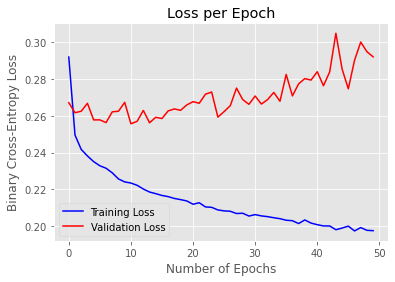

In [82]:
plt.plot(history.history['loss'],label = 'Training Loss', color = 'blue')
plt.plot(history.history['val_loss'],label = 'Validation Loss', color = 'red')
plt.xlabel('Number of Epochs')
plt.ylabel('Binary Cross-Entropy Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.show()

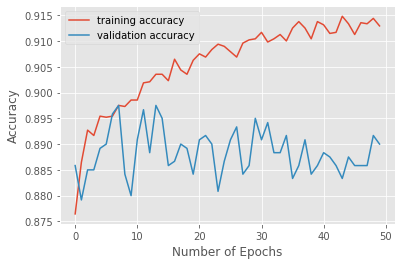

In [83]:
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Support Vector Machine

In [84]:
from sklearn import svm

svm_y = np.empty((len(features),1))

for i in range(len(features)):
    if features.iloc[i] == 1:
        svm_y[i] = 1
    else:
        svm_y[i] = -1

svm_y.astype(int)
x_train, x_test, y_train, y_test = train_test_split(feat,svm_y, test_size = 0.6, shuffle=True)


clf = svm.SVC()
clf.fit(x_train, y_train)
print('Training Accuracy: 'clf.score(x_train, y_train))
print('Validation Accuracy: 'clf.score(x_test, y_test))

/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.9008333333333334
0.8838888888888888


##  Generate the Test Graph and prepare Test Dataset

In [ ]:
df_test.age = df_test.age.apply(lambda x: 0 if x < 25 else(1 if x < 35 else(2 if x < 50 else(3 if x < 65 else 4))))

#df.job = df.job.apply(lambda x: 0 if x == 'unemployed' else(1 if x == 'services' \
#                            else(2 if x == 'management' else(3 if x == 'blue-collar' \
#                                else(4 if x == 'self-employed' else(5 if x == 'technician' \
#                                    else(6 if x == 'entrepreneur' else(7 if x == 'admin.' \
#                        else(8 if x =='student' else(9 if x == 'housemaid' \
#                            else(10 if x == 'retired' else 11)))))))))))

#df.job = df.job.apply(lambda x: 0 if x == 'unemployed' or 'unknown' else(1 if x == 'services' \
#                        or x == 'management' or x == 'admin.' else(2 if x == 'blue-collar' or x == 'technician' \
#                                    or x == 'housemaid' else(3 if x == 'self-employed' or x == 'entrepreneur' \
#                                        else(4 if x == 'student' else 5)))))

df_test.job = df_test.job.apply(lambda x: 0 if x == 'student' else(2 if x == 'retired' else(3 if x == 'unemployed' or x == 'unknown' else 1)))


df_test.marital = df_test.marital.apply(lambda x: 0 if x == 'single' else(1 if x == 'married' else 2))

df_test.education = df_test.education.apply(lambda x: 0 if x == 'primary' else(1 if x == 'secondary' else(2 if x == 'tertiary' else 3)))

df_test.default = df_test.default.apply(lambda x: 0 if x == 'no' else 1)

df_test.balance = df_test.balance.apply(lambda x: 0 if x < 0 else(1 if x < 69. else(2 if x < 444. else(3 if x < 1480 else 4))))

df_test.housing = df_test.housing.apply(lambda x: 0 if x == 'no' else 1)

df_test.loan = df_test.loan.apply(lambda x: 0 if x == 'no' else 1)

df_test.contact = df_test.contact.apply(lambda x: 0 if x == 'telephone' else(1 if x == 'cellular' else 2))

df_test.duration = df_test.duration.apply(lambda x: 0 if x < 104. else(1 if x < 185 else(2 if x < 329 else 3)))

df_test.pdays = df_test.pdays.apply(lambda x: 1 if x > 150 or x == -1 else 0)

df_test.poutcome = df_test.poutcome.apply(lambda x: 0 if x == 'failure' else(1 if x == 'success' else 2))

df_test.y = df_test.y.apply(lambda x: 0 if x == 'no' else 1)

df_test.drop(columns = ['day','month'],inplace=True)


In [ ]:
genvars = df_test.drop(columns=['previous','pdays','campaign','duration','contact','loan','default','poutcome','y'])
genvars

In [ ]:
# age
age_alpha0 = 0.90
age_beta1 = 0.80
age_beta2 = 0.60
age_beta3 = 0.40
age_beta4 = 0.20

aff_age = np.array([[age_alpha0,age_beta1,age_beta2,age_beta3,age_beta4],
                    [age_beta1,age_alpha0,age_beta1,age_beta2,age_beta3],
                    [age_beta2,age_beta1,age_alpha0,age_beta1,age_beta2],
                    [age_beta3,age_beta2,age_beta1,age_alpha0,age_beta1],
                    [age_beta4,age_beta3,age_beta2,age_beta1,age_alpha0]])


# job

job_alpha0 = 0.90 # self
job_beta_wf = 0.60 # workforce
job_beta_nwf = 0.60 # not worforce

#aff_job = np.array([[job_alpha0, job_beta_wf , job_beta_wf , job_beta_wf , job_beta_nwf, job_beta_nwf],
#                    [job_beta_nwf, job_alpha0, job_beta_wf, job_beta_wf, job_beta_nwf, job_beta_nwf],
#                    [job_beta_nwf, job_beta_wf, job_alpha0, job_beta_wf, job_beta_nwf, job_beta_nwf],
#                    [job_beta_nwf, job_beta_wf, job_beta_wf, job_alpha0, job_beta_nwf, job_beta_nwf],
#                    [job_beta_nwf, job_beta_wf, job_beta_wf, job_beta_wf, job_alpha0, job_beta_nwf],
#                    [job_beta_nwf, job_beta_wf, job_beta_wf, job_beta_wf, job_beta_nwf, job_alpha0]])

# employment
emp_alpha0 = 0.90 # self
emp_beta_wf = 0.75 # beta workforce / employed / unemployed vs student
emp_beta_ret = 0.70 # beta retired vs workforce
emp_beta_sr = 0.20 # gen gap student / retired

aff_job = np.array([[emp_alpha0,emp_beta_wf,emp_beta_sr,emp_beta_wf],
                    [emp_beta_wf,emp_alpha0,emp_beta_ret,emp_beta_wf],
                    [emp_beta_sr,emp_beta_ret,emp_alpha0,emp_beta_ret],
                    [emp_beta_wf,emp_beta_wf,emp_beta_ret,emp_alpha0]])


# marital

mar_alpha0 = 0.85
mar_beta1 = 0.65

aff_mar = np.array([[mar_alpha0, mar_beta1, mar_beta1],
                    [mar_beta1, mar_alpha0, mar_beta1],
                    [mar_beta1, mar_beta1, mar_alpha0]])

# education
edu_alpha0 = 0.85
edu_beta1 = 0.70
edu_beta2 = 0.55
edu_beta3 = 0.40

aff_edu = np.array([[edu_alpha0,edu_beta1,edu_beta2,edu_beta3],
                    [edu_beta1,edu_alpha0,edu_beta1,edu_beta2],
                    [edu_beta2,edu_beta1,edu_alpha0,edu_beta1],
                    [edu_beta3,edu_beta2,edu_beta1,edu_alpha0]])


# balance
inc_alpha0 = 0.85
inc_beta1 = 0.70
inc_beta2 = 0.60
inc_beta3 = 0.50
inc_beta4 = 0.40
inc_beta5 = 0.25

aff_bal = np.array([[inc_alpha0,inc_beta1,inc_beta2,inc_beta3,inc_beta4],
                    [inc_beta1,inc_alpha0,inc_beta1,inc_beta2,inc_beta3],
                    [inc_beta2,inc_beta1,inc_alpha0,inc_beta1,inc_beta2],
                    [inc_beta3,inc_beta2,inc_beta1,inc_alpha0,inc_beta1],
                    [inc_beta4,inc_beta3,inc_beta2,inc_beta2,inc_alpha0]])

# housing
hous_alpha0 = 0.60
hous_beta1 = 0.40

aff_hous = np.array([[hous_alpha0,hous_beta1],
                     [hous_beta1,hous_alpha0]])

# outcome

y_alpha0 = 0.95
y_beta1 = 0.25

aff_y = np.array([[y_alpha0,y_beta1],
                  [y_beta1,y_alpha0]])

aff = {}
aff = {0:aff_age, 1:aff_job ,2:aff_mar ,3:aff_edu ,4:aff_bal ,5:aff_hous}

In [ ]:
x = genvars.to_numpy()
x = x.astype(int)
x = x.T

P_u_v = np.empty((len(x.T),len(x.T)))
prob_u_v = np.empty((len(x),1))
u = np.empty((len(x),1))
v = np.empty((len(x),1))

# create probability for connection between u and v
for i in range(len(x.T)):
    u = x[:,i]

    for k in range(len(x.T)):
        v = x[:,k]

        for j in range(len(x)):
            aff_current = aff[j]
            prob_u_v[j] = aff_current[u[j],v[j]]

        P_u_v[i,k] = np.prod(prob_u_v) 

In [ ]:
A = np.triu(P_u_v,1)

for i in range(len(P_u_v)):
    for j in range(len(P_u_v)):
        if A[i,j] > np.random.rand():
            A[i,j] = 1
        else:
            A[i,j] = 0


In [ ]:
A = A + A.T
np.sum(A) / 2

In [ ]:
G_test = nx.from_numpy_matrix(A)

In [ ]:
test_features = pd.Series(df_test.y)

## Add Test Data to dgl Graph

In [ ]:
G_dgl_test = dgl.from_networkx(G_test)
feat_test = df_test.drop(columns=['y'])
#feat_test = pd.get_dummies(feat_test)
scale = StandardScaler()
feat_test = pd.DataFrame(scale.fit_transform(feat_test))

embedding_test = torch.tensor(feat_test.values,dtype=torch.float)

G_dgl_test.ndata['feat'] =  embedding_test
#G_dgl.ndata['train_mask'] = torch.zeros(len(G_dgl.nodes()), dtype=torch.bool).bernoulli(0.2)
G_dgl_test.ndata['label'] = torch.tensor(test_features)

In [ ]:
node_features = G_dgl_test.ndata['feat']
node_labels = G_dgl_test.ndata['label']
test_nids = G_dgl_test.nodes()
n_features = node_features.shape[1]
n_labels = int(node_labels.max().item() + 1)

## Define Inference Function

In [ ]:
def inference(model, graph, input_features, batch_size):
    nodes = torch.arange(graph.number_of_nodes())
    
    sampler = dgl.dataloading.MultiLayerNeighborSampler([None])  # one layer at a time, taking all neighbors
    dataloader = dgl.dataloading.NodeDataLoader(
        graph, nodes, sampler,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
        num_workers=0)
    
    with torch.no_grad():
        for l, layer in enumerate(model.layers):
            # Allocate a buffer of output representations for every node
            # Note that the buffer is on CPU memory.
            output_features = torch.zeros(
                graph.number_of_nodes(), model.n_hidden if l != model.n_layers - 1 else model.n_classes)

            for input_nodes, output_nodes, bipartites in tqdm.tqdm(dataloader):
                bipartite = bipartites[0].to(torch.device('cpu'))

                x = input_features[input_nodes]

                # the following code is identical to the loop body in model.forward()
                x = layer(bipartite, x)
                if l != model.n_layers - 1:
                    x = F.relu(x)
                    
                elif l == model.n_layers - 1:
                    x = F.log_softmax(x,dim=1)

                output_features[output_nodes] = x.cpu()
            input_features = output_features
    return output_features

## Load trained GraphSage model parameters and get Test results

In [ ]:
model.load_state_dict(torch.load('model.pt'))
all_predictions = inference(model, G_dgl_test, node_features, 6000)

In [ ]:
test_predictions = all_predictions[test_nids].argmax(1)
test_labels = node_labels[test_nids]
test_accuracy = sklearn.metrics.accuracy_score(test_predictions.numpy(), test_labels.numpy())
print('Test accuracy:', test_accuracy)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

print('Classification Accuracy test set {}'.format(accuracy_score(test_labels.numpy(),test_predictions.numpy())))
print('-------------------------------------------------------------')
print('Confusion Matrix test set:')
print(confusion_matrix(test_labels.numpy(),test_predictions.numpy()))